# ALMA WSU Size of Compute Estimate

The goal of this notebook is to estimate the ALMA WSU size of compute.

Sanjay would like the WSU equivalent of ngVLA SoC tables 2, 3, and 7 in csv format.

Table 2:
* fraction
* dump time
* channel size
* number of channels
* image linear size
* number of baselines
* vis/hr

Table 3:
* Wcorrection - no
* PB correction -- yes
* multi-scale --  no (currently)
* multi-term -- fractional BW -- > 30%

Table 7:
* fraction
* data rate
* required system performance

What I need in final table:
* fraction
* array
* dump time
* channel size
* number of channels
* number of spws
* image linear size
* number of baselines
* vis/hr
* fractional banwidth
* multi-term
* data rate
* required system performance


## Getting everyting set up

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import QTable,Table, vstack
from importlib import reload
import astropy.units as u
import wsu_db

In [2]:
# fix up custom units
gvis = u.def_unit('Gvis',namespace=globals())
u.add_enabled_units([gvis])

In [3]:
result_c7_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle7_20230128.ecsv')
result_c8_mous = QTable.read('data/wsu_datarates_mit_per_mous_cycle8_20230128.ecsv')

In [4]:
result_mous = vstack([result_c7_mous,result_c8_mous])

In [5]:
result_mous.columns

<TableColumns names=('mous','proposal_id','schedblock_name','array','nant_typical','nant_array','nant_all','band','ntarget','s_fov','s_resolution','mosaic','imsize','pb','cell','blc_npol','blc_nspw','blc_specwidth','blc_freq','blc_velres','blc_nchan_agg','blc_nchan_max','blc_bandwidth_max','blc_bandwidth_agg','wsu_freq','wsu_npol','wsu_bandwidth_early','wsu_bandwidth_later_2x','wsu_bandwidth_later_4x','wsu_bandwidth_spw','wsu_nspw_early','wsu_nspw_later_2x','wsu_nspw_later_4x','wsu_specwidth_finest','wsu_chanavg_finest','wsu_velres_finest','wsu_specwidth_stepped','wsu_chanavg_stepped','wsu_velres_stepped','wsu_specwidth_stepped2','wsu_chanavg_stepped2','wsu_velres_stepped2','wsu_tint','wsu_nchan_spw_finest','wsu_nchan_spw_stepped','wsu_nchan_spw_stepped2','wsu_frac_bw_early','wsu_frac_bw_later_2x','wsu_frac_bw_later_4x','wsu_frac_bw_spw','nbase_typical','nbase_array','nbase_all','L80','Project','SB_name','blc_tint','blc_ntunings','bp_time','flux_time','phase_time','pol_time','check_tim

## Add weights and system performance

In [194]:
reload(wsu_db)
wsu_db.calc_weights_and_sysperf(result_mous)

## Looking at the distribution of data rates

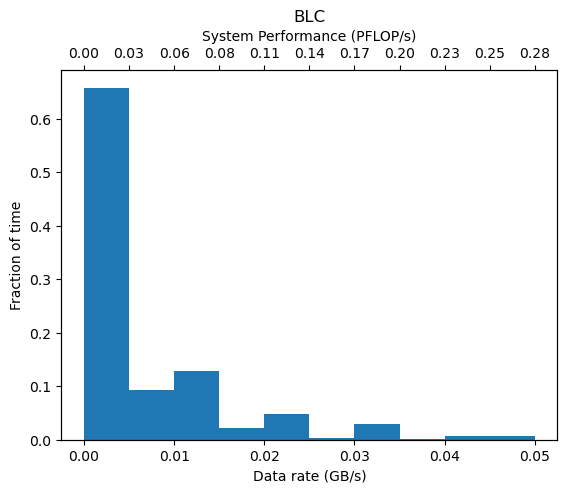

In [195]:
reload(wsu_db)
wsu_db.create_soc_result_plot(result_mous,bin_min=0,bin_max=0.05,nbin=10,
                              datarate_type='blc_datarate_typical',title='BLC')

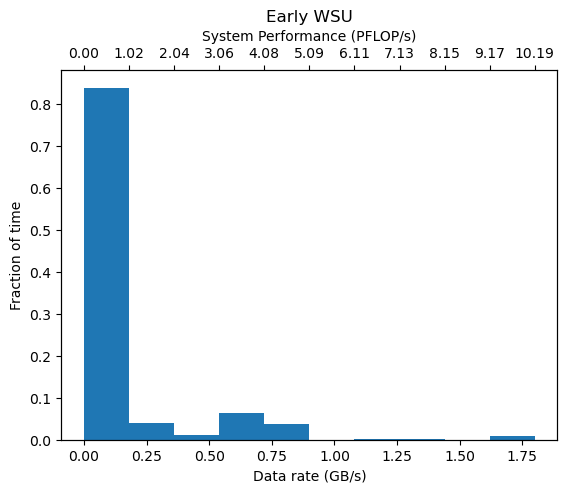

In [196]:
reload(wsu_db)
wsu_db.create_soc_result_plot(result_mous,bin_min=0,bin_max=1.8,nbin=10,
                             datarate_type='wsu_datarate_early_stepped2_typical',title='Early WSU')

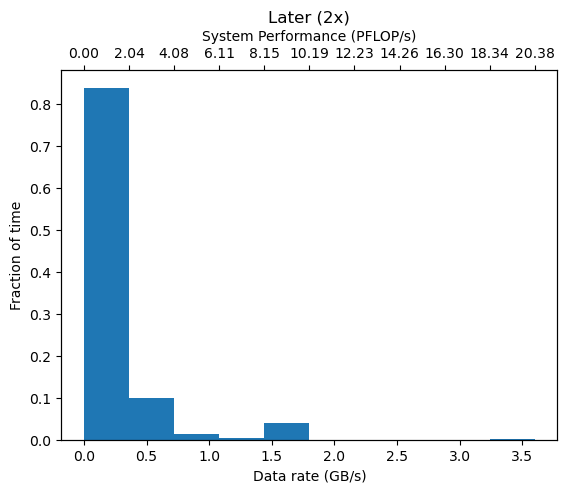

In [197]:
reload(wsu_db)
wsu_db.create_soc_result_plot(result_mous,bin_min=0,bin_max=3.6,nbin=10,
                             datarate_type='wsu_datarate_later_2x_stepped2_typical',title='Later (2x)')

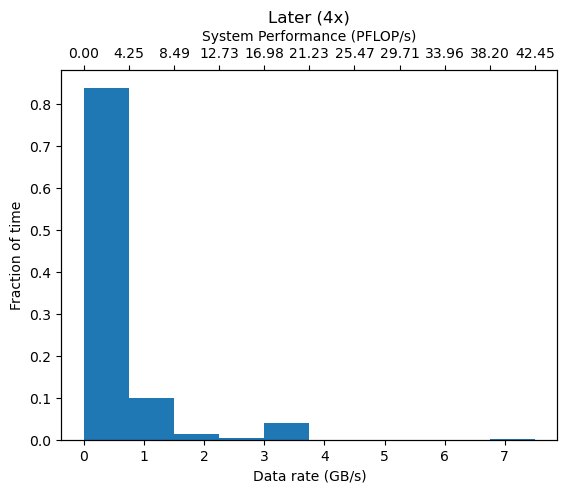

In [198]:
reload(wsu_db)
wsu_db.create_soc_result_plot(result_mous,bin_min=0,bin_max=7.5,nbin=10,
                             datarate_type='wsu_datarate_later_4x_stepped2_typical',title='Later (4x)')

In [200]:
reload(wsu_db)
wsu_db.create_db_for_sanjay(result_mous,filename='data/test_soc.ecsv')

## Now trying to figure out the required system performance

From the SoC document, it looks like the ratios between required system performance in PFLOPs/s and data rate GB/s is 5.66, i.e., UC 3 where 108.046GB/s * 5.66 = 611.754 PFLOPs/s. But the table is arithmetic intensity = 40 FLOPs/Byte. Which doesn't square with what I expected.

In [56]:
611.764/108.046

5.662069859134072

In [57]:
sysperf_blc = result_mous['blc_datarate_typical'] * 5.66

Text(0.5, 1.0, 'BLC')

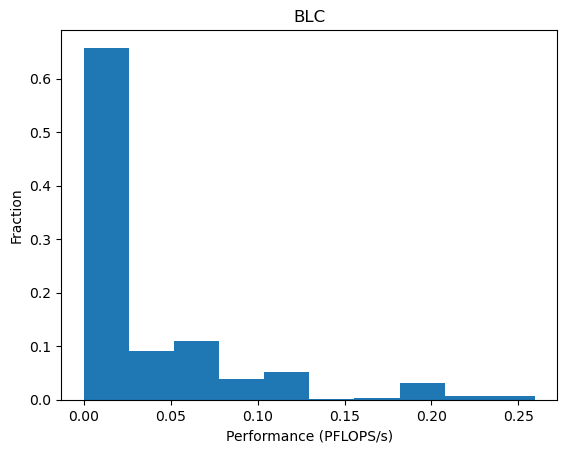

In [65]:
plt.hist(sysperf_blc.value,weights=result_mous['weights_all'])
plt.ylabel('Fraction')
plt.xlabel('Performance (PFLOPS/s)')
plt.title('BLC')

In [63]:
sysperf_wsu_early = result_mous['wsu_datarate_early_stepped2_typical'] * 5.66

Text(0.5, 1.0, 'WSU (early)')

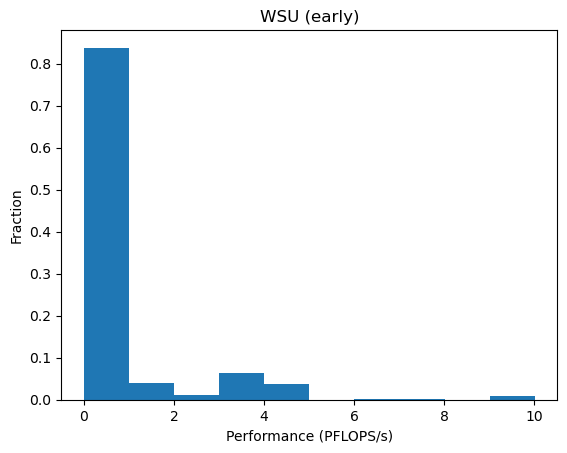

In [66]:
plt.hist(sysperf_wsu_early.value,weights=result_mous['weights_all'])
plt.ylabel('Fraction')
plt.xlabel('Performance (PFLOPS/s)')
plt.title('WSU (early)')

In [67]:
sysperf_wsu_later_2x = result_mous['wsu_datarate_later_2x_stepped2_typical'] * 5.66

Text(0.5, 1.0, 'WSU (later 2x)')

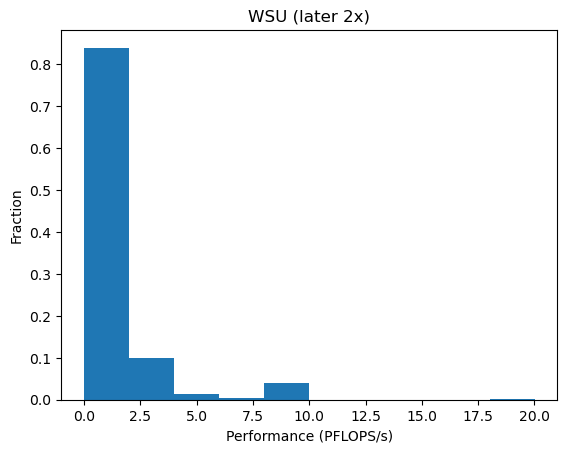

In [69]:
plt.hist(sysperf_wsu_later_2x.value,weights=result_mous['weights_all'])
plt.ylabel('Fraction')
plt.xlabel('Performance (PFLOPS/s)')
plt.title('WSU (later 2x)')

In [70]:
sysperf_wsu_later_4x = result_mous['wsu_datarate_later_4x_stepped2_typical'] * 5.66

Text(0.5, 1.0, 'WSU (later 4x)')

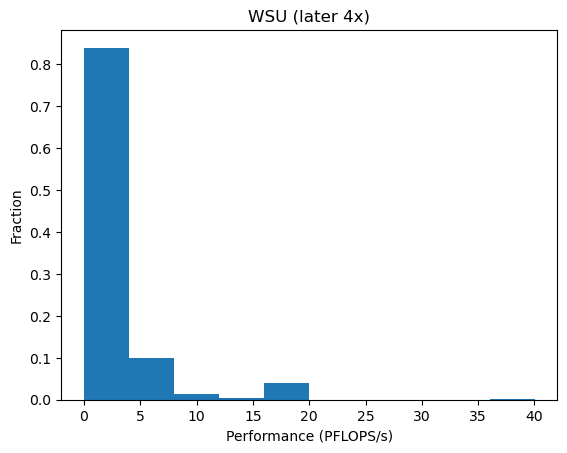

In [71]:
plt.hist(sysperf_wsu_later_4x.value,weights=result_mous['weights_all'])
plt.ylabel('Fraction')
plt.xlabel('Performance (PFLOPS/s)')
plt.title('WSU (later 4x)')

In [42]:
np.min(result_mous['wsu_datarate_early_stepped2_typical']*4.6

<Quantity 846825.3968254 1 / s>

In [ ]:
np.average(result_mous['wsu_datarate_early_stepped2_typical'].to(u.byte/u.s) * arith_intensity, 
          weights=result_mous['time_tot']/np.sum(result_mous['time_tot']))

In [45]:
np.max(result_mous['wsu_datarate_early_stepped2_typical'].to(u.byte/u.s) * arith_intensity)/1e9

<Quantity 70.73455238 1 / s>

In [ ]:
?plt.hist

In [ ]:
np.min(result_mous['wsu_datarate_later_2x_stepped2_typical'].to(u.byte/u.s) * arith_intensity)

In [ ]:
np.average(result_mous['wsu_datarate_later_2x_stepped2_typical'].to(u.byte/u.s) * arith_intensity, 
          weights=result_mous['time_tot']/np.sum(result_mous['time_tot']))

In [ ]:
np.max(result_mous['wsu_datarate_later_2x_stepped2_typical'].to(u.byte/u.s) * arith_intensity)

In [ ]:
np.min(result_mous['wsu_datarate_later_4x_stepped2_typical'].to(u.byte/u.s) * arith_intensity)

In [ ]:
np.average(result_mous['wsu_datarate_later_4x_stepped2_typical'].to(u.byte/u.s) * arith_intensity, 
          weights=result_mous['time_tot']/np.sum(result_mous['time_tot']))

In [ ]:
np.max(result_mous['wsu_datarate_later_4x_stepped2_typical'].to(u.byte/u.s) * arith_intensity)

In [ ]:
(data, bins, patches) = plt.hist(result_mous['wsu_datarate_early_stepped2_typical'].value)

In [ ]:
data

In [ ]:
bins